In [1]:
# Package import
from __future__ import print_function, division

import numpy as np
import time
import os
import copy
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.autograd import Variable

import sklearn.metrics as metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

plt.ion()   # interactive mode

In [23]:
# Set the directories for the data and the CSV files that contain ids/labels

'''
Please note: 

Folders under the directory: dir_images (showed below) have been set up before data input, which means 
there should be two folders named as:
1. 'train' which is randomly selected from all train data (we randomly selected 80%) for training process
2. 'val' which is randomly selected from all train data (we randomly selected 20%) for validation

Every folder above should has saved images in correct subfolders which are labeled as 'Belize' and 'Honduras'.
'''

#dir_images  = './data'
dir_images  = './fishing_ground'

In [24]:
# CNN
# Data augmentation and input
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((100,150)),
        transforms.CenterCrop((70,150)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.Grayscale(1),
        torchvision.transforms.ColorJitter(brightness=0.1
                                           #, contrast=0.1, saturation=0.1, hue=0.1
                                          ),
        #transforms.RandomRotation(90),
        transforms.RandomCrop((50,100)),
        transforms.ToTensor(),
        transforms.Normalize([0.485], [0.229])
    ]),
    'val': transforms.Compose([
        transforms.Resize((100,150)),
        #transforms.CenterCrop((100,150)),
        #transforms.Grayscale(1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    }

data_dir = dir_images
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, 
                                              num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

[['Harvest Cay' 'Jack Bank']
 ['Grunt Patch' 'Banco Tino']]


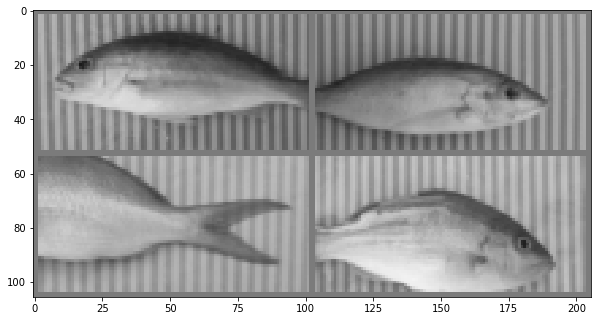

In [25]:
# Visualize Raw Data
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    mean = np.array([0.485])
    #std = np.array([0.229, 0.224, 0.225])
    std = np.array([0.229])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title,loc='right')
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs,nrow=2)

plt.rcParams['figure.figsize']=10,10

imshow(out, title=print(np.asarray([class_names[x] for x in classes]).reshape(2,2)))

In [26]:
def to_var(x, requires_grad=False, volatile=False):
    """
    Varialbe type that automatically choose cpu or cuda
    """
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, requires_grad=requires_grad, volatile=volatile)

In [27]:
# Define train model
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        #print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        #print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                if phase == 'train':
                    inputs = inputs.repeat(1,3,1,1)
                
                inputs = to_var(inputs, requires_grad=True)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    _, preds = torch.max(outputs, 1)
                    
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            if (epoch + 1) % 10 == 0 or epoch == 0:
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print('Epoch {}/{}'.format(epoch, num_epochs - 1))
                print('-' * 10)
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))
                print()
                    
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) 
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    # save best model
    torch.save(best_model_wts, "./model_grey_fg.pt")
    
    return model

In [30]:
# Original train model is pretrained ResNet34
model_ft = models.resnet34(pretrained=True)

#Set up linear layer
#num_ftrs = model_ft.fc.in_features
#model_ft.fc = nn.Linear(num_ftrs, 5)

#model_ft = model_ft.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

#O ptimizer Stochastic Gradient Decent
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.1, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.MultiStepLR(optimizer_ft, [50,75], gamma=0.1)

In [22]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100)

Epoch 0/99
----------
train Loss: 3.9376 Acc: 0.5859

Epoch 0/99
----------
val Loss: 1.0766 Acc: 0.3893

Epoch 9/99
----------
train Loss: 0.6703 Acc: 0.6234

Epoch 9/99
----------
val Loss: 9.3996 Acc: 0.4046

Epoch 19/99
----------
train Loss: 0.5466 Acc: 0.7344

Epoch 19/99
----------
val Loss: 0.9651 Acc: 0.6336

Epoch 29/99
----------
train Loss: 0.4143 Acc: 0.8219

Epoch 29/99
----------
val Loss: 1.9126 Acc: 0.7634

Epoch 39/99
----------
train Loss: 0.2835 Acc: 0.8891

Epoch 39/99
----------
val Loss: 0.6453 Acc: 0.8931

Epoch 49/99
----------
train Loss: 0.2087 Acc: 0.9250

Epoch 49/99
----------
val Loss: 1.1113 Acc: 0.6336

Epoch 59/99
----------
train Loss: 0.1317 Acc: 0.9484

Epoch 59/99
----------
val Loss: 0.6610 Acc: 0.8321

Epoch 69/99
----------
train Loss: 0.1109 Acc: 0.9609

Epoch 69/99
----------
val Loss: 0.6655 Acc: 0.8550

Epoch 79/99
----------
train Loss: 0.1075 Acc: 0.9641

Epoch 79/99
----------
val Loss: 1.0910 Acc: 0.8168

Epoch 89/99
----------
train Los

In [31]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100)

Epoch 0/99
----------
train Loss: 7.0879 Acc: 0.2727

Epoch 0/99
----------
val Loss: 1.8193 Acc: 0.3301

Epoch 9/99
----------
train Loss: 1.5087 Acc: 0.2971

Epoch 9/99
----------
val Loss: 4.8880 Acc: 0.3786

Epoch 19/99
----------
train Loss: 1.4037 Acc: 0.3570

Epoch 19/99
----------
val Loss: 3.0569 Acc: 0.1359

Epoch 29/99
----------
train Loss: 1.4198 Acc: 0.3614

Epoch 29/99
----------
val Loss: 2.0354 Acc: 0.1942

Epoch 39/99
----------
train Loss: 1.2898 Acc: 0.4523

Epoch 39/99
----------
val Loss: 1.8740 Acc: 0.4369

Epoch 49/99
----------
train Loss: 1.1555 Acc: 0.5078

Epoch 49/99
----------
val Loss: 1.9430 Acc: 0.3107

Epoch 59/99
----------
train Loss: 1.0685 Acc: 0.5366

Epoch 59/99
----------
val Loss: 3.4072 Acc: 0.2233

Epoch 69/99
----------
train Loss: 1.0259 Acc: 0.5366

Epoch 69/99
----------
val Loss: 3.3922 Acc: 0.2524

Epoch 79/99
----------
train Loss: 0.9913 Acc: 0.5809

Epoch 79/99
----------
val Loss: 2.6835 Acc: 0.2136

Epoch 89/99
----------
train Los